# IMPORTS

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

# Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

# GENERATOR

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

# Paramaters

In [12]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
lr = 1e-3
#lr = 1e-5
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

# Dataset Loader

In [13]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# SINGLE BATCH JUST IN CASE

In [16]:
# (real, _) = next(iter(loader))
# real = real.view(-1, 784).to(device)
# batch_size = real.shape[0]

In [17]:
# real.shape              # Fix batch size to 32   # Should come out torch.Size([32, 784])

# GENERATOR FROM GAN

In [18]:
# ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
# noise = torch.randn(batch_size, z_dim).to(device)
# fake = gen(noise)
# print(f"fake.shape : {fake.shape}")
# # Fix batch size to 32   # Should come out torch.Size([32, 784])

# COMBINE BOTH

# VECTOR QUANTISE LAYER

In [19]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Create embedding matrix
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        # Initialize embedding matrix
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, inputs):
        # inputs.shape = [batch_size, channel, height, width]
        batch_size, channel, height, width = inputs.shape

        # Flatten inputs
        inputs_flat = inputs.view(-1, self.embedding_dim)

        # Calculate distances between inputs and embeddings
        distances = torch.sum(inputs_flat**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(inputs_flat, self.embedding.weight.t())

        # Find nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Convert indices to one-hot vectors
        encoding_onehot = torch.zeros(encoding_indices.shape[0], self.num_embeddings,
                                      device=inputs.device)
        encoding_onehot.scatter_(1, encoding_indices, 1)

        # Quantize the input using the nearest embeddings
        quantized = torch.matmul(encoding_onehot, self.embedding.weight).view(batch_size, channel, height, width)

        # Calculate loss
        loss = self.commitment_cost * torch.mean((quantized.detach() - inputs)**2) + \
               torch.mean((quantized - inputs.detach())**2)

        # Add quantization to input for gradient calculation
        quantized = inputs + (quantized - inputs).detach()

        # Calculate perplexity
        encoding_probs = nn.functional.softmax(distances, dim=1)
        perplexity = torch.exp(-torch.sum(encoding_probs * torch.log(encoding_probs + 1e-10), dim=1)).mean()

        return loss, quantized, perplexity, encoding_indices

# RESIDUAL NETWORK

In [20]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

# ENCODER

In [21]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [22]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=1,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

# VQ-VAE Parameters

In [23]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 100

commitment_cost = 0.25

decay = 0


# VA-VAE Model

In [24]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
       
        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

# MODEL DECLERATION

In [25]:
disc = Discriminator(image_dim).to(device)
#gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

gen = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)


opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

# Define VQ-VAE

In [26]:
num_epochs =20

In [27]:
loss=nn.MSELoss()

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (real, _) in enumerate(loader):
        
        real = real.to(device)
        #print(f"{real.shape}")
        #real_copy= real
        #TRAIL LINE
        vq_loss, fake, perplexity = gen(real)
        
        total_loss += loss(real, fake) 
        
        fake = fake.view(-1, 784).to(device)
        real = real.view(-1, 784).to(device)
        #fake.shape


        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).view(-1)     # Noproblemo
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # Noproblemo
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2 
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()


        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output)) 
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        #real = real.view((32,1,28,28)).to(device)
        #_, fake, _ = gen(real)
        
        #print(f"{fake.shape}")
        #_, fake, _ = gen(real_copy)
        
        
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
        
    print(f"MSE : {total_loss/1875}")



Epoch [0/20] Batch 0/1875                       Loss D: 0.6642, loss G: 0.7796


# Plot Results

In [48]:
def plot_batch(batch_input_images, batch_output_images,num_images=64):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision.utils import make_grid
    
    # Grid from batch
    grid_in = make_grid(batch_input_images[:num_images])
    grid_out = make_grid(batch_output_images[:num_images])
    
    # Convert the grid to a numpy array and transpose the dimensions
    grid_in = grid_in.numpy().transpose((1, 2, 0))
    grid_out = grid_out.numpy().transpose((1, 2, 0))
    
    # Denormalize the pixel values
    grid_in = (grid_in - grid_in.min()) / (grid_in.max() - grid_in.min())
    grid_out = (grid_out - grid_out.min()) / (grid_out.max() - grid_out.min())
    
    # Subplots to see result side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax1.imshow(grid_in)
    ax1.set_title("Original Dataset", fontsize=40)
    
    ax2.imshow(grid_out)
    ax2.set_title("Output Dataset", fontsize=40)
   

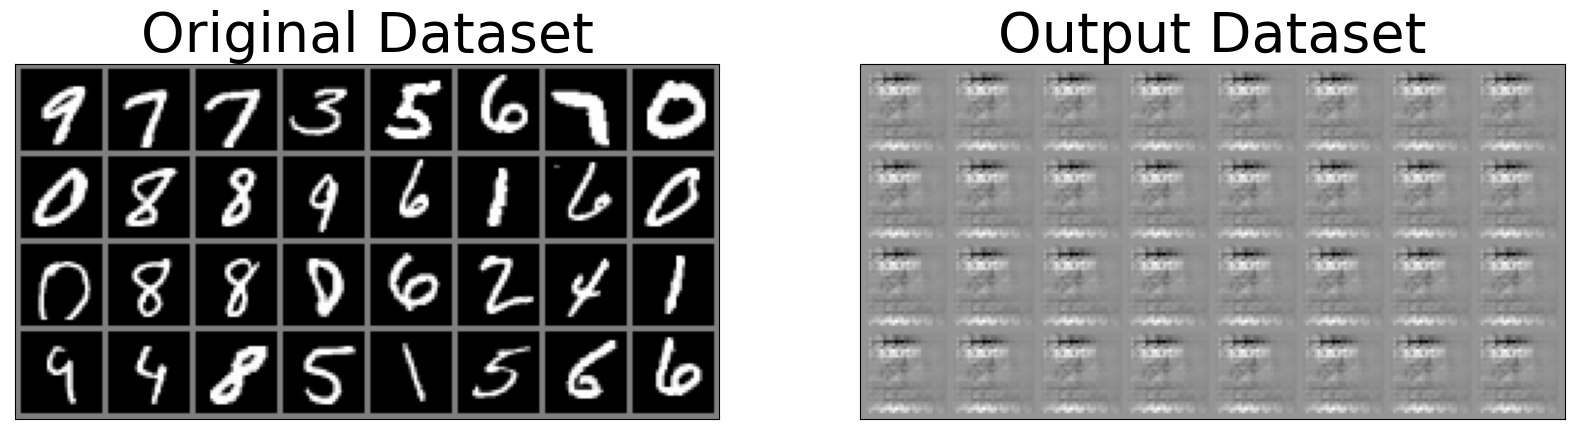

In [49]:
batch_input_images, labels = next(iter(loader)) # 1st batch of test set
batch_input_images = batch_input_images.to(device)  # Do this if trained on CUDA
_,batch_output_images,_ = gen(batch_input_images)     # Pass batch trough model 

batch_output_images = batch_output_images.cpu()     # Needs this for matplotlib
batch_input_images = batch_input_images.cpu()       # Needs this for matplotlib

plot_batch(batch_input_images, batch_output_images,num_images=64)